In [1]:
from scipy.io import loadmat
import numpy as np
from scipy.optimize import minimize
from datetime import datetime
now = datetime.now

import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import os
import pickle

import json

from scipy.stats import chi2

from copy import deepcopy

In [2]:
SaveFitFigs = False
SaveFitData = False
dpiN = 1000
dark_plots = False
n_sig = 8
n_print_sigfig = 2
if dark_plots:
    dark='darkbg/'
    q = mpl.rc_params_from_file('matplotlibrc_dark')
else:
    dark = 'whitebg/'
    mpl.rcParams.update(mpl.rcParamsDefault)
SavePlotDir_Exp2  = '../Results/2021-12-20/Exp2/'+dark+'FittingFigs/'
SaveDataDir_Exp2  = '../Results/2021-12-20/Exp2/'+'Pickles/'
LoadDataDir_Exp2 = SaveDataDir_Exp2 # The other notebook stored the pickle in the same folder
if SaveFitFigs:
    if not os.path.exists(SavePlotDir_Exp2):
        os.makedirs(SavePlotDir_Exp2)
if SaveFitData:
    if not os.path.exists(SaveDataDir_Exp2):
        os.makedirs(SaveDataDir_Exp2)


In [3]:
if dark_plots:
    mpl.rcParams.update(q)
    %matplotlib inline
    mpl.rcParams.update({
                    #'legend.borderpad': 0.3,
                    #'legend.borderaxespad': 0.25,
#                     'legend.columnspacing': 0.6,
#                     'legend.handlelength': 0.7,
                    #'legend.handleheight': 0.4,
                    #'legend.handletextpad': 0.2,
#                     'legend.labelspacing': 0.45,
#                     'text.usetex': True,
                    'font.size':13,
                    })
else:
    %matplotlib inline
    # mpl.rcParams.update(mpl.rcParamsDefault)
    font = {
    #    'weight' : 'normal',
       'size'   : 15,
       'family': 'Times New Roman'}
    plt.rc('font', **font)
#     mpl.rcParams.update({'font.family':'serif'})

In [4]:
%load_ext autoreload

In [5]:
from B_calc_script import TopFunctionOneExpAnyFreq
from B_calc_script import signif

In [6]:
%autoreload 2

# Load data

In [7]:
Exp2_data_filename = LoadDataDir_Exp2+'Exp2_cut_averaged_data.pk'

In [8]:
with open(Exp2_data_filename,'rb') as file_obj:
    Exp2_data_cut = pickle.load(file_obj)

## Load parameters ##

In [9]:
with open('../Params/Exp2_dimensions_and_locations.json', 'r') as fp:
    params_dims_locs = json.load(fp)

In [10]:
params_dims_locs

{'D_wheel_sensor': 8,
 'D_wheel_sample': 0.2,
 'rotor_dims': {'height': 10,
  'outer_radius': 18.9992,
  'inner_radius': 15.0114,
  'hole_radius': 2.49936,
  'bar_width': 7.01},
 'AW_location': {'coordinate': 'cartesian',
  'location': "np.array([0.5*(rotor_dims['outer_radius']+rotor_dims['inner_radius']),0,rotor_dims['height']/2+D_wheel_sensor])"},
 'AV_location': {'coordinate': 'cartesian',
  'location': "np.array([-rotor_dims['outer_radius']-D_wheel_sensor,0,0])"},
 '3He locations': {'1': {'coordinate': 'cartesian',
   'location': "np.array([0,-rotor_dims['outer_radius']-D_wheel_sample,0])"},
  '2': {'coordinate': 'cartesian',
   'location': "np.array([0,-rotor_dims['outer_radius']-D_wheel_sample + 0.07,0])"},
  '3': {'coordinate': 'cartesian',
   'location': "np.array([0,-rotor_dims['outer_radius']-D_wheel_sample-0.07,-1.2])"},
  '4': {'coordinate': 'cartesian',
   'location': "np.array([0,-rotor_dims['outer_radius']-D_wheel_sample,1])"}}}

In [11]:
rtr_dims = params_dims_locs['rotor_dims']

In [12]:
for key in rtr_dims:
    rtr_dims[key]= signif(rtr_dims[key],n_sig)

In [13]:
Exp2_AW_sensor_loc =params_dims_locs['AW_location']
string_to_parse = params_dims_locs['AW_location']['location']
Exp2_AW_sensor_loc['location'] = eval(string_to_parse.replace('rotor_dims','rtr_dims').replace('D_wheel_sensor','params_dims_locs[\'D_wheel_sensor\']'))

In [14]:
Exp2_AV_sensor_loc =params_dims_locs['AV_location']
string_to_parse = params_dims_locs['AV_location']['location']
Exp2_AV_sensor_loc['location'] = eval(string_to_parse.replace('rotor_dims','rtr_dims').replace('D_wheel_sensor','params_dims_locs[\'D_wheel_sensor\']'))

# Calculate fitted field, chi, and plot #

In [15]:
Exp2_settings = {
    'rotor dimensions':rtr_dims,
    'sensor locations':{
        'AW':Exp2_AW_sensor_loc,
        'AV':Exp2_AV_sensor_loc},
    # 'bar location':0,
#     'DC shifts':[DC_shift_AVx,DC_shift_AVy,DC_shift_AWy,DC_shift_AWz]
#    'deltaB':1 #picoTesla
}

In [16]:

nu = 5

Exp2_data = {
    'theta':np.concatenate([Exp2_data_cut['theta avg'][nu]
    # ,360+Exp2_data_cut['theta avg'][nu]
    ]), 
    #theta positive for ac, negative for clockwise
    'B':{
        'AW':{
            'Z':np.concatenate([
                # Exp2_data_cut['AW']['Z avg'][nu],
                                Exp2_data_cut['AW']['Z avg'][nu]['B']]),
            'Y':np.concatenate([
                # Exp2_data_cut['AW']['Y avg'][nu],
                                Exp2_data_cut['AW']['Y avg'][nu]['B']])
        },
        'AV':{
#             'X':np.concatenate([Exp2_data_cut['AV']['Z avg'][nu]+20,Exp2_data_cut['AV']['Z avg'][nu]+20]),
            'X':np.concatenate([
                # Exp2_data_cut['AV']['X avg'][nu],
                                Exp2_data_cut['AV']['X avg'][nu]['B']]),
            'Y':np.concatenate([
                # Exp2_data_cut['AV']['Y avg'][nu],
                                Exp2_data_cut['AV']['Y avg'][nu]['B']])
#             'Y':np.concatenate([-Exp2_data_cut['AV']['Y avg'][nu]-70,-Exp2_data_cut['AV']['Y avg'][nu]-70])
        }        
    },
    'error in B':{
        'AW':{
            'Z':Exp2_data_cut['AW']['Z avg'][nu]['sigma'],
            'Y':Exp2_data_cut['AW']['Y avg'][nu]['sigma']
        },
        'AV':{
            'X':Exp2_data_cut['AV']['X avg'][nu]['sigma'],
            'Y':Exp2_data_cut['AV']['Y avg'][nu]['sigma']
        }
    }
            }

Bar location: 93.564672°
DC shifts: [-34.820795, 7.1447531, 24.454786, -34.934989] pT
Source 1 is located at {'coordinate': 'polar', 'location': [13.34881, 8.9320463, 4.5407797]}
Source 1 has moment {'coordinate': 'polar', 'moment': [13.86328, -18.593463, -21.081236]}
Source 2 is located at {'coordinate': 'polar', 'location': [15.024318, 274.11433, -4.9914269]}
Source 2 has moment {'coordinate': 'polar', 'moment': [12.91915, -39.755946, 21.922618]}
Source 3 is located at {'coordinate': 'polar', 'location': [15.146636, 93.498957, -3.9010842]}
Source 3 has moment {'coordinate': 'polar', 'moment': [37.875578, -30.16728, -33.317131]}
Total number of points are 396
Reduced chi sq = 0.023874559


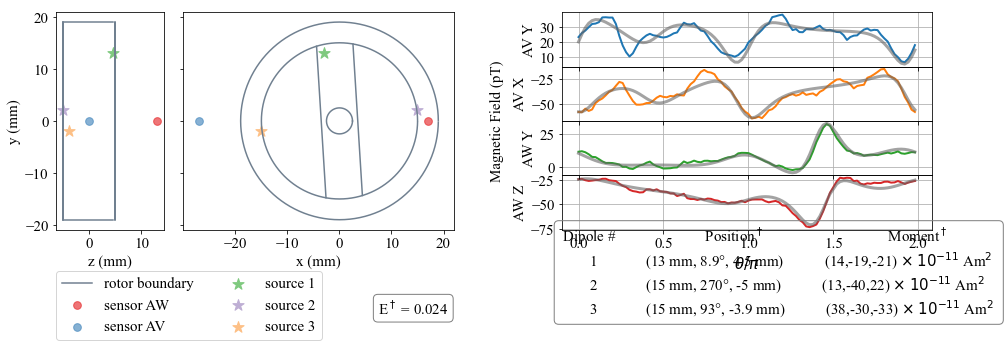

In [17]:
# nowtext = now().strftime("%Y%m%d%H%M")
nowtext = '3sources'
fitplotfilename = SavePlotDir_Exp2+'FittedData_{}Hz_'.format(nu)+nowtext+'.png'
fitdatafilename = SaveDataDir_Exp2+'FittedData_{}Hz_'.format(nu)+nowtext+'.pk'

Exp2_plot_settings = {
    'plot':True,
#     'memo':'{} Hz (AV X&Y inverted)'.format(nu),
    # 'memo':'{} Hz anticlockwise'.format(nu),
    'saveplot':SaveFitFigs,
    'figname':fitplotfilename,
    'dpi' : dpiN,
    'doubleplot':False,
    'print sigfigs':n_print_sigfig
}

Exp2_optimization_settings = {
    'print':True,
    'number of sources':3,
    'location dimensions':3,
    'moment dimensions':3,
    'location coordinate system':'polar',
    'moment coordinate system':'polar',
    'chi tolerance':n_sig+1,
    'optimize DC shifts':True,
    'optimize bar location':True,
    'significant figures':n_sig
}
Exp2_save_settings ={
    'save fit data':False,
}
Exp2_all_settings = {
    'experiment settings':Exp2_settings,
    'data':Exp2_data,
    'optimization settings':Exp2_optimization_settings,
    'plot settings':Exp2_plot_settings,
    'save settings':Exp2_save_settings
    
}

Exp2_Opt_Params_3_sources = signif([ 13.34880956,   8.93204632,   4.54077966,  13.86327989,
       -18.5934633 , -21.08123588,  15.02431798, 274.11433097,
        -4.99142693,  12.91915001, -39.7559461 ,  21.92261841,
        15.14663565,  93.49895702,  -3.9010842 ,  37.87557816,
       -30.16727982, -33.31713104, -34.93498927,  24.45478623,
         7.14475312, -34.82079508,  93.56467221],n_sig)



chi = TopFunctionOneExpAnyFreq(Exp2_Opt_Params_3_sources,Exp2_all_settings)

In [18]:
fitplotfilename

'../Results/2021-12-20/Exp2/whitebg/FittingFigs/FittedData_5Hz_3sources.png'

In [19]:
initial = []
initial.append(Exp2_Opt_Params_3_sources)

for ip in range(len(Exp2_Opt_Params_3_sources)):
#     print(ip)
    arr_dum = Exp2_Opt_Params_3_sources.copy()
    arr_dum[ip] = Exp2_Opt_Params_3_sources[ip]*1.5
#     print(arr_dum)
    initial.append(arr_dum)

In [20]:
Exp2_all_settings['plot settings']['plot'] = 0
Exp2_all_settings['optimization settings']['print'] = 0
# opt_res_Exp2 = minimize(TopFunctionOneExpAnyFreq,Exp2_Opt_Params,Exp2_all_settings,
#                         method = 'Nelder-Mead',options = {'maxfev': 10000,'maxiter': 10000,'adaptive':True,'fatol':.01})
# opt_res_Exp2 = minimize(TopFunctionOneExpAnyFreq,Exp2_Opt_Params,Exp2_all_settings,
#                         method = 'Powell',options = {'maxfev': 1000,'maxiter': 1000,'ftol':1})
opt_res_Exp2 = minimize(TopFunctionOneExpAnyFreq,Exp2_Opt_Params_3_sources,Exp2_all_settings,
                        method = 'Nelder-Mead',options = {'maxfev': 30000,'maxiter': 20000,'fatol':1e-2,'xatol' : 1e-3
                                                         ,'initial_simplex':initial
                                                         })

Reduced chi sq = 0.023874559
Source 1 not in rotor
Parsing was not successful, errorcode -5
Reduced chi sq = 0.033890583
Source 1 not in rotor
Parsing was not successful, errorcode -5
Reduced chi sq = 0.031527053
Reduced chi sq = 0.047904943
Reduced chi sq = 0.060889755
Source 2 not in rotor
Parsing was not successful, errorcode -5
Source 2 not in rotor
Parsing was not successful, errorcode -5
Source 2 not in rotor
Parsing was not successful, errorcode -5
Reduced chi sq = 0.024758407
Reduced chi sq = 0.033397468
Reduced chi sq = 0.026933208
Source 3 not in rotor
Parsing was not successful, errorcode -5
Reduced chi sq = 0.135442582
Source 3 not in rotor
Parsing was not successful, errorcode -5
Reduced chi sq = 0.03459399
Reduced chi sq = 0.030971979
Reduced chi sq = 0.032183125
Reduced chi sq = 0.128480595
Reduced chi sq = 0.086825133
Reduced chi sq = 0.042852158
Reduced chi sq = 0.225907813
Reduced chi sq = 0.540568659
Source 2 not in rotor
Parsing was not successful, errorcode -5
Sour

Bar location: 93.80428°
DC shifts: [-34.685745, 7.1407111, 24.434661, -34.626164] pT
Source 1 is located at {'coordinate': 'polar', 'location': [13.532114, 8.8385702, 4.5478913]}
Source 1 has moment {'coordinate': 'polar', 'moment': [14.34292, -17.962905, -20.581996]}
Source 2 is located at {'coordinate': 'polar', 'location': [15.019746, 272.49134, -4.9999983]}
Source 2 has moment {'coordinate': 'polar', 'moment': [15.365764, -37.721231, 22.543651]}
Source 3 is located at {'coordinate': 'polar', 'location': [15.162966, 92.81385, -3.8680686]}
Source 3 has moment {'coordinate': 'polar', 'moment': [38.721389, -29.375115, -33.357068]}
Total number of points are 396
Reduced chi sq = 0.023814449


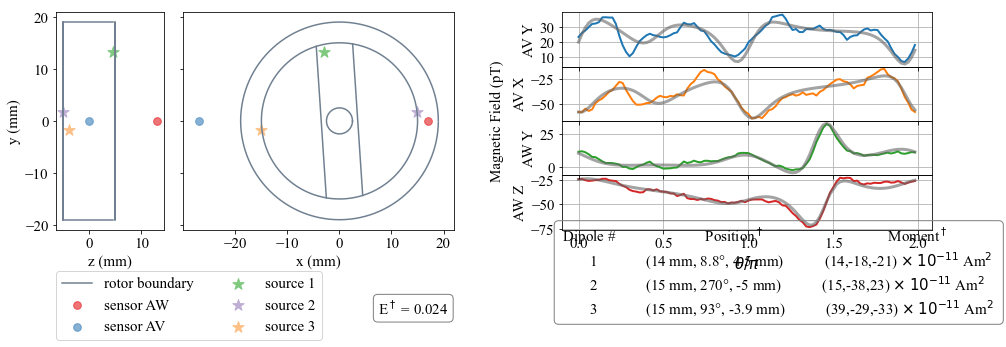

In [21]:
Exp2_all_settings['plot settings']['plot'] = True
Exp2_plot_settings['saveplot']=SaveFitFigs
Exp2_all_settings['optimization settings']['print'] = 1
Exp2_all_settings['save settings']['save fit data'] = SaveFitData
Exp2_all_settings['save settings']['fit data filename'] = fitdatafilename

# nowtext = now().strftime("%Y%m%d%H%M")
Exp2_plot_settings['figname']=SavePlotDir_Exp2+'FittedData_{}Hz'.format(nu)+nowtext+'optimized'+'.png'
chi_opt = TopFunctionOneExpAnyFreq(opt_res_Exp2['x'],Exp2_all_settings)

In [22]:
data_to_write = opt_res_Exp2['x']

In [23]:
data_to_write

array([ 13.53211358,   8.83857017,   4.54789126,  14.34292036,
       -17.96290457, -20.58199603,  15.01974648, 272.49134026,
        -4.99999832,  15.36576384, -37.72123144,  22.54365071,
        15.16296609,  92.81384978,  -3.8680686 ,  38.72138889,
       -29.37511485, -33.35706848, -34.6261642 ,  24.43466095,
         7.1407111 , -34.68574464,  93.80428018])

In [24]:
if SaveFitData:
    with open(SaveDataDir_Exp2+'FittedDipoles_{}Hz_'.format(nu)+nowtext+'.pk','wb') as file_obj:
        pickle.dump(data_to_write,file_obj)
    with open(SaveDataDir_Exp2+'FittedDipoles_{}Hz_'.format(nu)+nowtext+'.json','w',encoding = 'utf-8') as file_obj:
        json.dump(data_to_write.tolist(),file_obj)
    

In [25]:
with open(SaveDataDir_Exp2+'FittedDipoles_{}Hz_'.format(nu)+nowtext+'.json','r',encoding = 'utf-8') as file_obj:
    blah = json.loads(file_obj.read())